In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import torch
from fastai.vision.all import *
print(torch.__version__)

2.5.1


In [2]:
import fastai
print(fastai.__version__)
# 2.7.18
import multiprocessing
print(multiprocessing.cpu_count())

2.7.18
10


In [3]:
# Load a dataset
path = untar_data(URLs.PETS)
dls = ImageDataLoaders.from_name_re(path, get_image_files(path / "images"), pat=r'(.+)_\d+.jpg', item_tfms=Resize(224))
print(path)
path.ls()

/Users/ivostoyanov/.fastai/data/oxford-iiit-pet


(#2) [Path('/Users/ivostoyanov/.fastai/data/oxford-iiit-pet/images'),Path('/Users/ivostoyanov/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
files = get_image_files(path/"images")
len(files)

7390

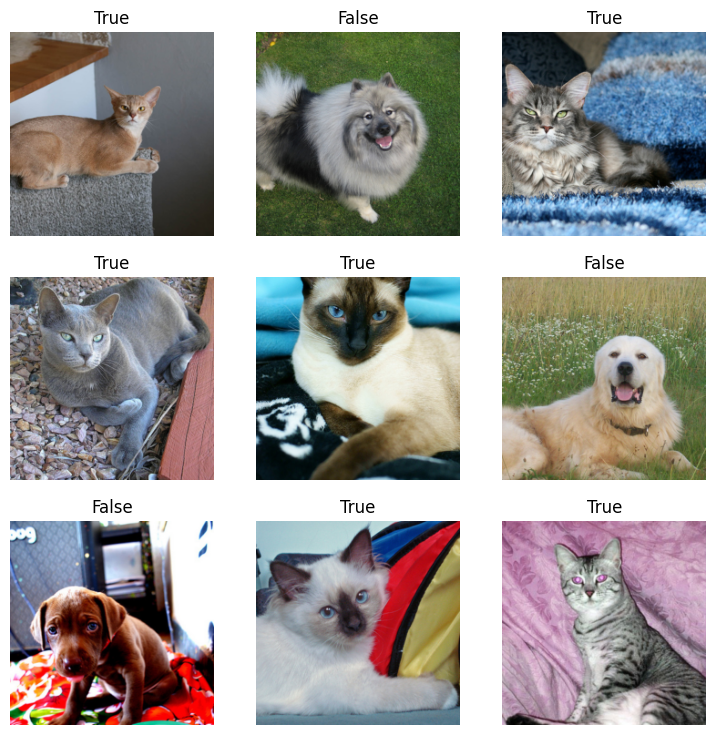

In [5]:
# Cats picture start with Uppercase, dogs - lower
def label_func(f): return f[0].isupper()
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))
dls.show_batch()

In [7]:
print("MPS Available:", torch.backends.mps.is_available())

device = torch.device("mps")
#device = torch.device("cpu")
learn = vision_learner(dls, resnet34, metrics=error_rate)
# Explicitly move to MPS
learn.model = learn.model.to(device)
learn.dls.to(device)# Train the model
learn.fine_tune(1)

MPS Available: True


In [27]:
# SAVE
learn.save('cat-dog_trained_model')

Path('/Users/ivostoyanov/.fastai/data/oxford-iiit-pet/models/cat-dog_trained_model.pth')

In [8]:
learn.predict(files[0])

('True', tensor(1), tensor([3.9499e-11, 1.0000e+00]))

In [9]:
learn.predict(files[1])

('False', tensor(0), tensor([1.0000e+00, 2.0896e-06]))

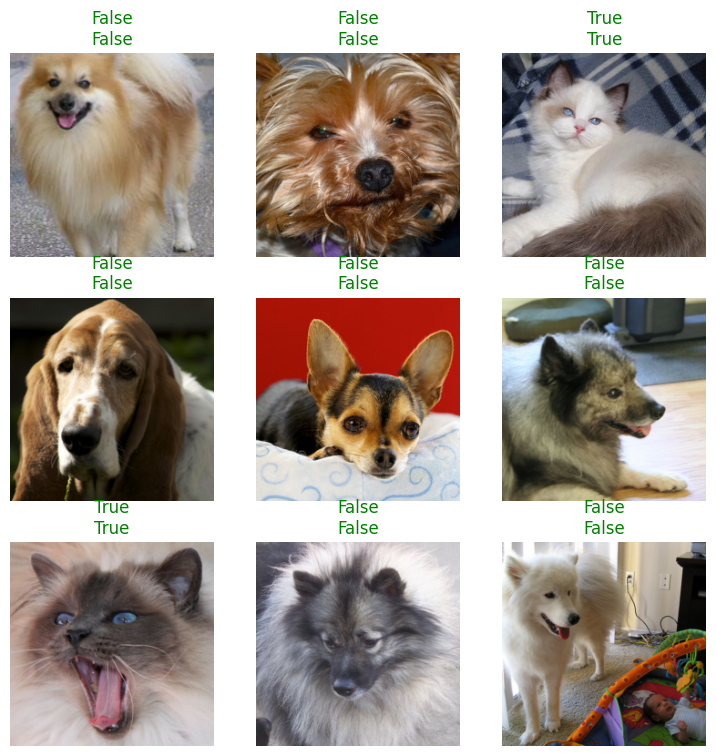

In [10]:
learn.show_results()

Classifying breeds

Since it’s pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:


In [13]:
import re
pat = r'^(.*)_\d+.jpg'
name = files[0].name
match = re.search(pat, name)
print(match.groups()[0])


Egyptian_Mau


In [14]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

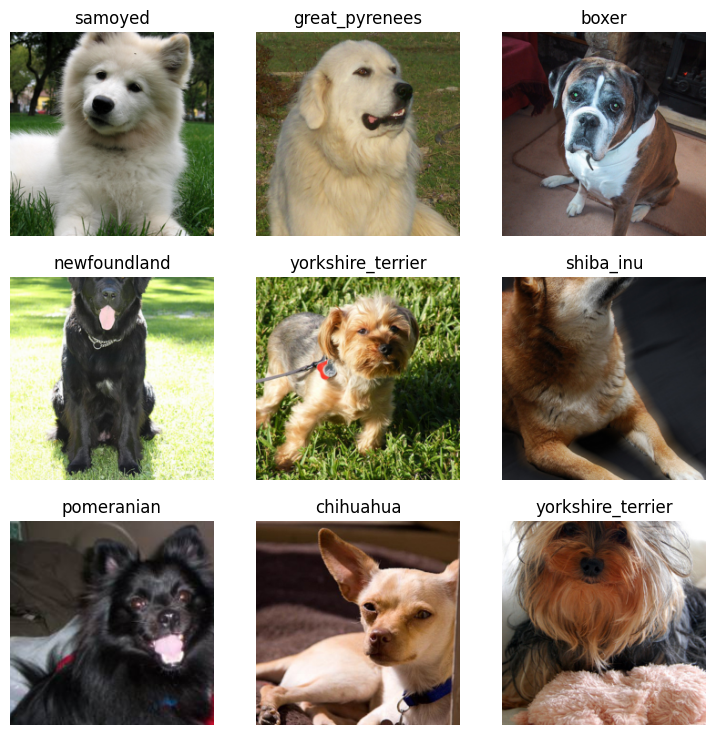

In [15]:
dls.show_batch()

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our DataLoaders to use data augmentation:

In [33]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(448), batch_tfms=aug_transforms(size=224))

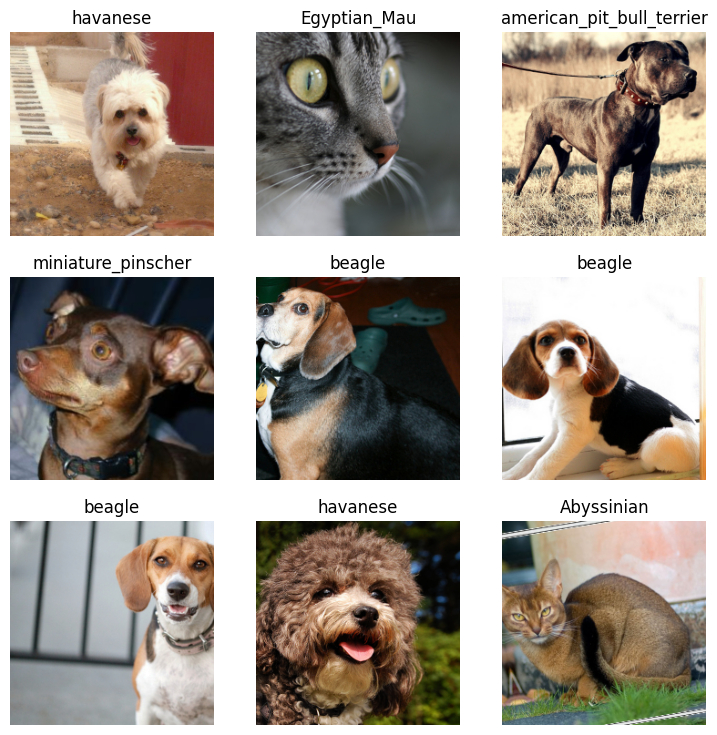

In [34]:
dls.show_batch()

In [32]:
# Some additional debugging steps
print("Model device:", next(learn.model.parameters()).device)
print("Learner type:", type(learn))
print("Model type:", type(learn.model))
print("PYTORCH_ENABLE_MPS_FALLBACK", os.getenv("PYTORCH_ENABLE_MPS_FALLBACK"))


Model device: mps:0
Learner type: <class 'fastai.learner.Learner'>
Model type: <class 'torch.nn.modules.container.Sequential'>
PYTORCH_ENABLE_MPS_FALLBACK 1


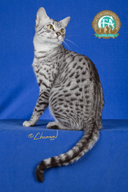

In [22]:
img = PILImage.create(files[0])
img.to_thumb(192)

In [31]:
learn.load('cat-dog_trained_model', weights_only=False)

In [35]:
import ipywidgets as widgets
from IPython.display import display

try:
    uploader = widgets.FileUpload(
        accept='',  # Accept all file types
        multiple=False
    )
    display(uploader)
except ImportError:
    print("Please install ipywidgets: pip install ipywidgets")

FileUpload(value=(), description='Upload')

{'name': 'siamese-1-.png', 'type': 'image/png', 'size': 240458, 'content': <memory at 0x146e22800>, 'last_modified': datetime.datetime(2024, 12, 9, 1, 36, 56, 615000, tzinfo=datetime.timezone.utc)}


<Axes: >

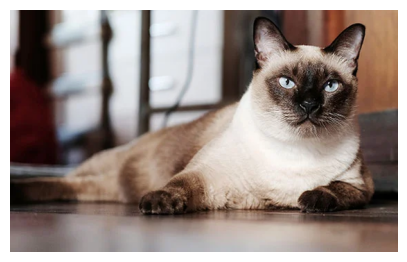

In [49]:
# Access the first (and likely only) item in the tuple
file_dict = uploader.value[0]

# Create the image using the content
import io
img = PILImage.create(io.BytesIO(file_dict['content']))

file_info = uploader.value[0]
print(file_info)

# Display the image (colors seem bad, saved img is good?, thumb is good)
img.show()

In [47]:
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")


Is this a cat?: True.
Probability it's a cat: 1.000000


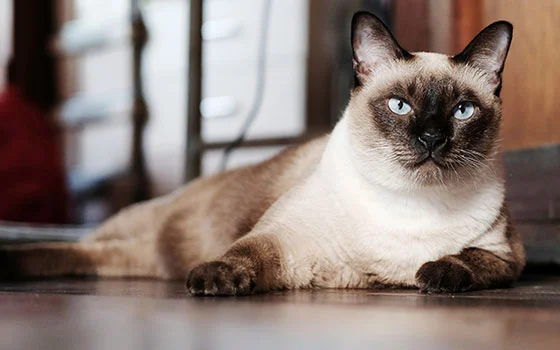

In [52]:
img.to_thumb(560)